# Mindset d'un réseau de neurones avec la régression logistique

Dans ce workshop, vous allez coder un réseau de neurones pour reconnaître des chats à partir d'une image. Vous apprendrez le mindset (= l'état d'esprit) du fonctionnement d'un réseau de neurones, et acquérir, de manière générale, une idée de ce qu'est le deep learning.

**Instructions:**
- N'utilisez pas de boucles for ou while à moins qu'on ne vous le demande explicitement.


**Vous allez apprendre à:**
- Construire l'architecture générale d'un modèle d'apprentissage incluant:
    - l'initialisation des paramètres
    - le calcul de la fonction de coût et de son gradient
    - l'utilisation d'un algorithme d'optimisation
- Regrouper les trois fonctions ci-dessus pour le modèle.

## 1 - Packages ##

Importons d'abord les packages suivant dont vous aurez besoin:
- [numpy](www.numpy.org) est le package fondamental pour le calcul scientifique avec Python.
- [h5py](http://www.h5py.org) est un package permettant d'intéragir avec un jeu de données stocké dans un fichier H5.
- [matplotlib](http://matplotlib.org) est une bibliothèque connue pour afficher des graphiques en Python.
- [PIL](http://www.pythonware.com/products/pil/) et [scipy](https://www.scipy.org/) sont utilisés ici pour tester votre modèle avec vos propres photos à la fin.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## 2 - Overview de la problématique##

**Problématique**: 
Nous vous avons donné un jeu de données ("data.h5") contenant:
    - un training set de m_train images, chacune labellisées comme étant un chat (y=1) ou non-chat(y=0)
    - un test set de m_test images, chacune labellisées comme étant un chat ou non-chat
    - chaque image est de la forme (num_px, num_px, 3) où 3 correspond aux trois canaux RGB. Chaque image est donc carrée de côté num_px.

Vous allez construire un algorithme simple de reconnaissance d'images qui pourra classifier correctement les images de chats des autres.

Explorons d'abord notre jeu de données. Commençons par l'importer.

In [20]:
# Chargement des données
x_train_orig, y_train, x_test_orig, y_test, classes = load_dataset()

Nous avons ajouté "_orig" à la fin des jeux de données d'images (train et test) car nous allons par la suite les traiter. En général, lorque l'on vous donne un jeu de données, il n'est jamais parfait. Vous devrez toujours passer par une étape de `nettoyage` appelée `préprocessing`. Après cette étape, vous vous retrouverez avec x_train et x_test (y_train et y_test n'ont pas besoin de préprocessing)

Chaque ligne de votre x_train_orig et y_test_orig est un tableau représentant une image. Vous pouvez en visualiser une en exécutant le code suivant. Vous pouvez aussi changer la valeur de `index` si vous voulez voir d'autres images.

y = [1], ceci est une photo de chat


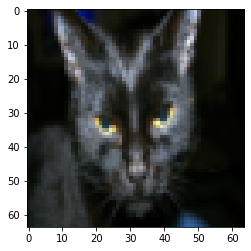

In [21]:
# Exemple d'une image
index = 25
plt.imshow(x_train_orig[index])
if classes[np.squeeze(y_train[:, index])] == b'cat':
    print("y = " + str(y_train[:, index]) + ", ceci est une photo de chat")
else:
    print("y = " + str(y_train[:, index]) + ", ceci n'est pas une photo de chat")

Beaucoup de bugs en deep learning proviennent du fait que les dimensions de matrices/vecteurs sont incorrectes. En y faisant attention, vous éviterez de nombreux bugs.


**Exercise:** Trouvez les bonnes valeurs de:
    - m_train (nombre d'images de train)
    - m_test (nombre d'images de test)
    - num_px (longueur/largeur d'une image)
    
Rappelez vous que x_train_orig est un numpy array de la forme (m_train, num_px, num_px, 3). Par exemple, vous pouvez accéder à `m_train` en écrivant `x_train_orig.shape[0]`.

In [22]:
### Début du code ### (≈ 3 lignes de code)
m_train = x_train_orig.shape[0]
m_test = x_test_orig.shape[0]
num_px = x_train_orig.shape[1]
### Fin du code ###

print ("Nombre d'exemples de train: m_train = " + str(m_train))
print ("Nombre d'exemples de test: m_test = " + str(m_test))
print ("Longueur/Largeur de chaque image: num_px = " + str(num_px))
print ("Chaque image est de size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("x_train shape: " + str(x_train_orig.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test_orig.shape))
print ("y_test shape: " + str(y_test.shape))

Nombre d'exemples de train: m_train = 209
Nombre d'exemples de test: m_test = 50
Longueur/Largeur de chaque image: num_px = 64
Chaque image est de size: (64, 64, 3)
x_train shape: (209, 64, 64, 3)
y_train shape: (1, 209)
x_test shape: (50, 64, 64, 3)
y_test shape: (1, 50)


**Résultat attentu pour m_train, m_test and num_px**: 

<table style="width:15%">
  <tr>
    <td>m_train</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
  
</table>


Pour des raisons pratiques, vous devriez transformer vos images de la forme (num_px, num_px, 3) en un numpy array de la forme (num_px $*$ num_px $*$ 3, 1). Après cela, nos jeux de données (train et test) seront des numpy array dans laquelle chaque colonne représente une image applatie ("flatten" en anglais). Il devrait y avoir m_train et m_test colonnes.


**Exercise:** 
Transformer les jeux de données de train et de test de façon à ce que les images de la forme (num_px, num_px, 3) soient applatie en simples vecteurs de la forme (num\_px $*$ num\_px $*$ 3, 1).

Petite astuce: lorsque vous voulez applatir une matrice X de la forme (a,b,c,d) en une matrice X_flatten de la forme (b$*$c$*$d, a): 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T est la transposée de X
```

In [23]:
### Début du code ### (≈ 2 lignes de code)
x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1).T
### Fin du code ###

print ("x_train_flatten shape: " + str(x_train_flatten.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test_flatten shape: " + str(x_test_flatten.shape))
print ("y_test shape: " + str(y_test.shape))
print ("check 1 random après reshaping: " + str(x_train_flatten[5:10,1]))
print ("check 2 random après reshaping: " + str(x_train_flatten[17:22,34]))

x_train_flatten shape: (12288, 209)
y_train shape: (1, 209)
x_test_flatten shape: (12288, 50)
y_test shape: (1, 50)
check 1 random après reshaping: [182 188 179 174 213]
check 2 random après reshaping: [20 16  3 22 15]


**Résultat attendu**: 

    x_train_flatten shape: (12288, 209)
    y_train shape: (1, 209)
    x_test_flatten shape: (12288, 50)
    y_test shape: (1, 50)
    check 1 random après reshaping: [182 188 179 174 213]
    check 2 random après reshaping: [20 16  3 22 15]

Pour représenter des images en couleurs, les canaux rouges, verts et bleus (RGB) doivent être spécifiés pour chaque pixel, et la valeur de chaque pixel correspond en fait à un vecteur de 3 nombres compris entre 0 et 255.

Une étape de préprocessing assez courante en machine learning est de centrer et normaliser votre jeu de données, ce qui signifie que vous allez calculer la moyenne de tout le numpy array, puis diviser chaque exemple de ce jeu de données par l'écart-type. Pour les images, il est plus simple et plus pratique  de diviser uniquement chaque ligne du dataset par 255 (la valeur maximum d'un canal de couleur). Vous vous retrouvez alors avec un numpy array comprenant des nombres entre 0 et 1.

Normalisons notre jeu de données:

In [24]:
x_train = x_train_flatten/255.
x_test = x_test_flatten/255.

<font color='blue'>
    
**Ce que vous devez retenir:**

Les étapes courantes de préprocessing:
- Analyser les données en affichant les dimensions et les formes du jeu de données (m_train, m_test, num_px, etc.)
- Transformer les jeux de données de façon à ce que chaque exemple devienne un vecteur de dimension (num_px \* num_px \* 3, 1)
- Normaliser les données

## 3 - Architecture générale de l'algorithme d'apprentissage ##

C'est le moment de construire un simple algorithme pour reconnaître un chat d'un non-chat d'une image.

Vous allez construire une régression logistique, tout en suivant le mindset (l'état d'esprit) d'un réseau de neurones. La figure suivante vous explique pourquoi **la régression logistique** est un réseau de neurones très simple !

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Expression mathématique de l'algorithme**:

Pour chaque exemple $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Le coût est ensuite calculé en additionnant toutes les **losses** (pertes) de chaque exemple.
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Etapes clés**:
Dans cet exercice, vous allez traiter les étapes suivantes:
    - Initialiser les paramètres du modèle
    - Apprendre les paramètres au modèle en minimisant le coût
    - Utiliser les paramètres appris pour faire des prédictions (sur le jeu de données de test)
    - Analyser les résultats et conclure

N'hésitez pas à appeler l'un des assistants si vous avez besoin d'aide.

## 4 - Construire les différentes parties de l'algorithme ## 

Les étapes principales pour construire un réseau de neurones sont:
1. Définir la structure du modèle (comme le nombre de features (fonctionnalités) en entrée)
2. Initialiser les paramètres du modèle
3. Boucle:
    - Calculer la perte actuelle (forward propagation)
    - Calculer le gradient courant (backward propagation)
    - Mettre à jour les paramètres (descente de gradient)
    
### 4.1 - Fonctions utiles

**Exercise**: 
En utilisant votre code du workshop dernier (sur Python et numpy), implémenter la fonction sigmoïde. Comme vous l'avez vu dans la figure précédente, vous avez besoin de calculer $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ pour faire des prédictions. Utilisez np.exp().

In [31]:
def sigmoid(z):
    """
    Arguments:
    z -- Un nombre scalaire ou un numpy array
    
    Return:
    s -- sigmoid(z)
    """

    ### Début du code ### (≈ 1 ligne de code)
    s = 1 / (1 + np.exp(-z))
    ### Fin du code ###
    
    return s

In [32]:
print ("sigmoid([-1, 0, 0.5, 2, 3]) = " + str(sigmoid(np.array([-1, 0, 0.5, 2, 3]))))

sigmoid([-1, 0, 0.5, 2, 3]) = [0.26894142 0.5        0.62245933 0.88079708 0.95257413]


**Résultat attendu**: 

sigmoid([-1, 0, 0.5, 2, 3]) = [0.26894142 0.5        0.62245933 0.88079708 0.95257413]

### 4.2 - Initialisation des paramètres

**Exercise:** 
Implémentez l'initialisation des paramètres dans la cellule suivante. Vous devez initialiser w comme un vecteur ne contenant que des 0. Si vous ne savez pas quelle fonction numpy utiliser, renseignez vous sur np.zeros() dans la doc de numpy.

In [33]:
def initialize(dim):
    """
    Cette fonction crée un vecteur de zeros de shape (dim, 1) pour w et initialise b à 0
    
    Argument:
    dim -- size du vecteur w qu'on veut (ou le nombre de paramètres dans ce cas)
    
    Returns:
    w -- vecteur initialisé de shape (dim, 1)
    b -- nombre scalaire initialisé correspondant au biais
    """
    
    ### Début du code ### (≈ 2 lignes de code)
    w = np.zeros((dim, 1))
    b = 0
    ### Fin du code ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [34]:
dim = 5
w, b = initialize(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
b = 0


**Résultat attendu**: 

w = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
 
b = 0

Pour les images, w doit être de la forme (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Forward et Backward propagation

Maintenant que vos paramètres sont initialisés, vous pouvez écrire les étapes de forward et backward propagation pour apprendre les paramètres.


**Exercise:** Implémentez la fonction `propagate()` qui va calculer la fonction de coût et son gradient.

**Indices**:

Forward Propagation:
- On vous donne X
- Vous calculez $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Vous calculez la fonction de coût: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Voici les deux formules que vous utiliserez: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [73]:
def propagation(w, b, X, Y):
    """
    Arguments:
    w -- les poids, un numpy array of size (num_px * num_px * 3, 1)
    b -- le biais, un nombre scalaire
    X -- matrice de size (num_px * num_px * 3, nombre d'exemples)
    Y -- le vecteur correspondant aux labels (0 si non-chat, 1 si chat) de size (1, nombre d'exemples)

    Return:
    cost -- coût
    dw -- gradient de la loss de même shape que w
    db -- gradient de la loss de même shape que b

    Conseils:
    - Ecrivez votre code étape par étape pour la propagation. np.log(), np.dot()
    """

    m = X.shape[1]

    # Forward Propagation (de X à cost)
    ### Début du code ### (≈ 2 lignes de code)
    # calcule l'activation
    A = sigmoid(np.dot(w.T, X) + b)

    # compute cost
    # cost = - m * Y * np.log(A) + (1 - Y) * np.log(1 - A)

    cost = - np.sum(np.log(A) * Y + (1 - Y) * np.log(1 - A)) / m
    # print(cost)
    ### Fin du code ###

    # Backward Propagation (pour trouver les gradients)
    ### Début du code ### (≈ 2 lignes de code)
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m
    ### Fin du code ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [74]:
w, b, X, Y = np.array([[4.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagation(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.999923  ]
 [2.39975403]]
db = 7.288578855054369e-05
cost = 8.800077000774023


**Résultat attendu**:

<table style="width:50%">
    <tr>
        <td>  dw   </td>
      <td> [[0.999923  ]
         [2.39975403]]</td>
    </tr>
    <tr>
        <td>  db  </td>
        <td> 7.288578855054369e-05 </td>
    </tr>
    <tr>
        <td>  cost  </td>
        <td> 8.800077000774023 </td>
    </tr>

</table>

### 4.4 - Optimisation

- Vous avez initialisé vos paramètres.
- Vous savez aussi calculer une fonction de coût et son gradient.
- Maintenant, vous voulez mettre à jour les paramètres en utilisant la descente de gradient.


**Exercise:** Ecrivez la fonction d'optimisation. Le but est d'apprendre $w$ et $b$ en minimisant la fonction de coût $J$. Pour un paramètre $\theta$ donné, la formule de mise à jour est $ \theta = \theta - \alpha \text{ } d\theta$, où $\alpha$ correspond au **learning rate** (taux d'apprentissage).

In [81]:
def optimization(w, b, X, Y, n_iterations, learning_rate, print_cost=False):
    """
    Arguments:
    w -- les poids, numpy array de size (num_px * num_px * 3, 1)
    b -- le biais, un scalaire
    X -- matrice de size (num_px * num_px * 3, nombre d'exemples)
    Y -- le vecteur correspondant aux labels (0 si non-chat, 1 si chat) de size (1, nombre d'exemples)
    n_iterations -- nombre d'itérations dans la boucle d'optimisation
    learning_rate -- le pas d'apprentissage
    print_cost -- True pour afficher la loss toutes les 100 fois
    
    Returns:
    params -- dictionnaire python contenant les poids w et le biais b
    grads -- dictionnaire contenant les gradients de w et de b grâce à la fonction de coût
    costs -- list de tous les coûts calculés pendant l'optimisation, cela nous permettra d'afficher la courbe d'apprentissage

    Conseils:
    Vous aurez besoin d'écrire 2 étapes et d'itérer à travers elles:
        1) Calculez le coût et le gradient des paramètres. Utilisez propagation()
        2) Updatez les paramètres en utilisant la descente de gradient pour w et b 
    
    """
    
    costs = []
    
    for i in range(n_iterations):
        
        
        # Calcul du coût et du gradient (≈ 1-4 lignes de code)
        ### Début du code ###
        grads, cost = propagation(w, b, X, Y)
        ### Fin du code ###
        
        # Récupérer les dérivées depuis grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update (≈ 2 lignes de code)
        ### Début du code ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### Fin du code ###
        
        # Stockez les coûts
        if i % 100 == 0:
            costs.append(cost)
        
        # Afficher le coût toutes les 100 itérations
        if print_cost and i % 100 == 0:
            print ("Coût après iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [82]:
params, grads, costs = optimization(w, b, X, Y, n_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[ 3.11567021]
 [-0.10995646]]
b = 1.9850788219795317
dw = [[0.89699851]
 [2.07122651]]
db = 0.09736680112994216


**Résultat attendu**: 

w = [[ 3.11567021]
 [-0.10995646]]

b = 1.9850788219795317

dw = [[0.89699851]
 [2.07122651]]

db = 0.09736680112994214

**Exercise:** La fonction précedente a permis d'afficher les poids w et le biais b appris. On peut les utiliser pour prédire les labels d'un jeu de données X. Implémentez la fonction `prediction()`. Il y a 2 étapes pour calculer les prédictions:

1. Calculer $\hat{Y} = A = \sigma(w^T X + b)$

2. Convertir les entrées de A en 0 (si activation <= 0.5) ou 1 (si activation > 0.5) et les stocker dans un vecteur `Y_prediction`.

In [92]:
def prediction(w, b, X):
    '''
    Arguments:
    w -- les poids, numpy array de size (num_px * num_px * 3, 1)
    b -- le biais, un scalaire
    X -- matrice de size (num_px * num_px * 3, nombre d'exemples)

    Returns:
    Y_prediction -- un numpy array (vecteur) contenant toutes les prédictions (0/1) des exemples de X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Calculez le vecteur "A" correspondant aux prédictions si un chat est présent dans l'image
    ### Début du code ### (≈ 1 ligne de code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### Fin du code ###

    for i in range(A.shape[1]):

        # Convertissez les prédictions A[0,i] en p[0,i]
        ### Début du code ### (≈ 4 lignes de code)
        Y_prediction[0] = (A > 0.5)
        ### Fin du code ###

    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [93]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.2,-2.4],[1.4,2.5,0.6]])
print ("predictions = " + str(prediction(w, b, X)))

predictions = [[1. 1. 0.]]


**Résultat attendu**: 

<table style="width:30%">
    <tr>
         <td>
             predictions
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
    
**Ce que vous devez retenir:**

Vous avez implémenté plusieurs fonctions qui:
- initialise (w, b)
- optimise la perte de façon itérative pour apprendre les paramètres (w, b):
    - calcul du coût et de son gradient
    - mise à jour des paramètres en utilisant la descente de gradient
- utilise les (w, b) appris pour prédire les labels d'un jeu de données d'exemple

## 5 - Mergez toutes les fonctions dans un modèle unique ##

Vous allez maintenant voir comment le modèle global est structuré en intégrant tous les blocs (les fonctions que vous avez implémentées) ensemble, dans le bon ordre.

**Exercice**: Implémentez la fonction "model". Utilisez les notations suivantes:
    - Y_pred_test pour vos prédictions sur le jeu de données de test
    - Y_pred_train pour vos prédictions sur le jeu de données de tain
    - w, costs, grads pour les résultats de optimization()

In [98]:
def model(X_train, Y_train, X_test, Y_test, n_iterations = 2000, learning_rate = 0.5, print_cost=False):
    """ 
    Arguments:
    X_train -- jeu de données de train représenté par un numpy array de shape (num_px * num_px * 3, m_train)
    Y_train -- labels des données de train représenté par un numpy array (vecteur) of shape (1, m_train)
    X_test -- jeu de données de test représenté par un numpy array de shape (num_px * num_px * 3, m_test)
    Y_test -- labels des données de test représenté par un numpy array (vecteur) of shape (1, m_test)
    n_iterations -- nombre d'itérations dans la boucle d'optimisation
    learning_rate -- le pas d'apprentissage
    print_cost -- True pour afficher la loss toutes les 100 fois
    

    Returns:
    d -- dictionnaire python contenant toutes les informations du modèle.
    """
    
    ### Début du code ###

    # Initialisez les paramètres avec des 0 (≈ 1 ligne de code)
    w, b = initialize(X_train.shape[0])

    # Descente de gradient (≈ 1 ligne de code)
    parameters, grads, costs = optimization(w, b, X_train, Y_train, n_iterations, learning_rate, print_cost)

    # récupérez les paramètres depuis parameters
    w = parameters["w"]
    b = parameters["b"]

    # Prédisez les exemples de train et de test (≈ 2 lignes de code)
    Y_pred_test = prediction(w, b, X_test)
    Y_pred_train =  prediction(w, b, X_train)

    ### Fin du code ###

    # Print les erreurs de train et de test
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_pred_test": Y_pred_test, 
         "Y_pred_train" : Y_pred_train, 
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": n_iterations}
    
    return d

Exécutez la cellule suivante pour entraîner votre modèle.

In [99]:
d = model(x_train, y_train, x_test, y_test, n_iterations = 2000, learning_rate = 0.006, print_cost = True)

Coût après iteration 0: 0.693147
Coût après iteration 100: 0.649811
Coût après iteration 200: 0.538312
Coût après iteration 300: 0.439262
Coût après iteration 400: 0.349825
Coût après iteration 500: 0.278498
Coût après iteration 600: 0.249764
Coût après iteration 700: 0.231178
Coût après iteration 800: 0.215229
Coût après iteration 900: 0.201339
Coût après iteration 1000: 0.189110
Coût après iteration 1100: 0.178249
Coût après iteration 1200: 0.168533
Coût après iteration 1300: 0.159788
Coût après iteration 1400: 0.151873
Coût après iteration 1500: 0.144677
Coût après iteration 1600: 0.138104
Coût après iteration 1700: 0.132079
Coût après iteration 1800: 0.126537
Coût après iteration 1900: 0.121421
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %


**Résultat attendu**: 

Coût après iteration 0: 0.693147

Coût après iteration 100: 0.649811

Coût après iteration 200: 0.538312

Coût après iteration 300: 0.439262

Coût après iteration 400: 0.349825

Coût après iteration 500: 0.278498

Coût après iteration 600: 0.249764

Coût après iteration 700: 0.231178

Coût après iteration 800: 0.215229

Coût après iteration 900: 0.201339

Coût après iteration 1000: 0.189110

Coût après iteration 1100: 0.178249

Coût après iteration 1200: 0.168533

Coût après iteration 1300: 0.159788

Coût après iteration 1400: 0.151873

Coût après iteration 1500: 0.144677

Coût après iteration 1600: 0.138104

Coût après iteration 1700: 0.132079

Coût après iteration 1800: 0.126537

Coût après iteration 1900: 0.121421

train accuracy: 99.52153110047847 %

test accuracy: 68.0 %




**Commentaire**: Votre accurary (précision) de train est très proche de 100%. C'est très bien, votre modèle est fonctionnel et sait très bien reconnaître les chats du jeu de données de train. Cependant, l'accuracy de test est de 68%. C'est n'est pas si mal pour le modèle simple qu'on a construit étant donné le petit jeu de données fourni, mais ne vous inquiéter pas, nous construirons un meilleur modèle dans un futur workshop.

Vous avez aussi remarqué que le modèle à surinterpréter (overfit) les données de train. Nous verrons plus tard des méthodes pour réduire la surinterprétation (en utilisant la régularisation par exemple). Utilisez le code ci-dessous pour afficher la fonction de coût et ses gradients.

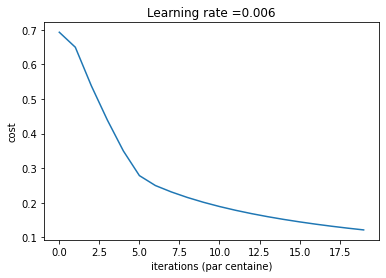

In [100]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (par centaine)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interprétation**:
Vous pouvez voir que le coût décroît. Cela montre que les paramètres sont en cours d'apprentissage. Cependant, vous voyez aussi que le modèle s'entraîne trop sur le jeu de données de train. Essayez d'augmenter le nombre d'itérations dans la cellule au dessus et re-exécutez les cellules. Vous devriez voir que la précision du jeu de donnée d'entraînement augmente mais que celui de test baisse. C'est ce qu'on appelle l'overfitting.

Quelques sources utiles:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c